<a href="https://colab.research.google.com/github/wolfos20/CodSoft-Internship/blob/main/stock_price_prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\# Stock Price Prediction

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model


# Reading data using parse date
As it is timeseries data so we have to read the data by parsing date means making data column as index.

In [9]:

df_final = pd.read_csv("/content/drive/MyDrive/AAPL.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)

<ipython-input-9-e1e441e14aaa>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_final = pd.read_csv("/content/drive/MyDrive/AAPL.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_final.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.605903,0.616319,0.598090,0.616319,0.447268,53033600
1990-01-03,0.621528,0.626736,0.614583,0.619792,0.449788,113772800
1990-01-04,0.619792,0.638889,0.616319,0.638021,0.463017,125740800
1990-01-05,0.635417,0.638889,0.621528,0.622396,0.451678,69564800
1990-01-08,0.621528,0.631944,0.614583,0.631944,0.458607,58982400


In [11]:

df_final.shape

(2594, 6)

In [10]:
df_final.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2594.000000,2594.000000,2594.000000,2594.000000,2594.000000,2.594000e+03
mean,54.573919,55.169814,53.986552,54.598382,52.478962,2.059973e+08
std,44.494624,45.063258,43.934519,44.519246,44.870330,1.691014e+08
min,13.856071,14.271429,13.753571,13.947500,12.029553,4.100000e+07
25%,24.118750,24.333125,23.903125,24.136073,21.845253,9.906485e+07
50%,35.938750,36.127500,35.782501,35.928749,33.732573,1.433088e+08
75%,62.715623,64.526251,62.217501,63.669999,62.276530,2.508434e+08
max,182.630005,182.940002,179.119995,182.009995,180.434296,1.460852e+09


In [12]:
df_final.isnull().values.any()

False

<Axes: xlabel='Date'>

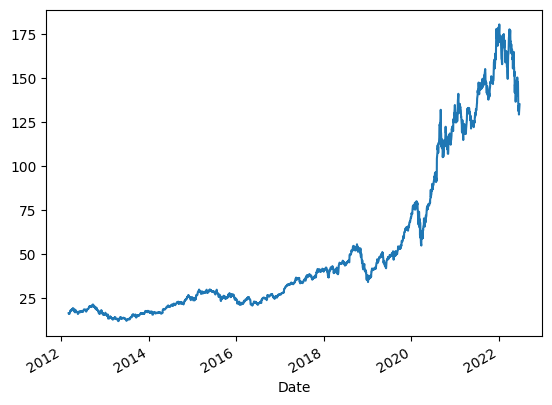

In [13]:
df_final['Adj Close'].plot()

# Correlation Analysis

In [14]:
X=df_final.drop(['Adj Close'],axis=1)
X=X.drop(['Close'],axis=1)

<Axes: title={'center': 'Correlation with Adj Close'}>

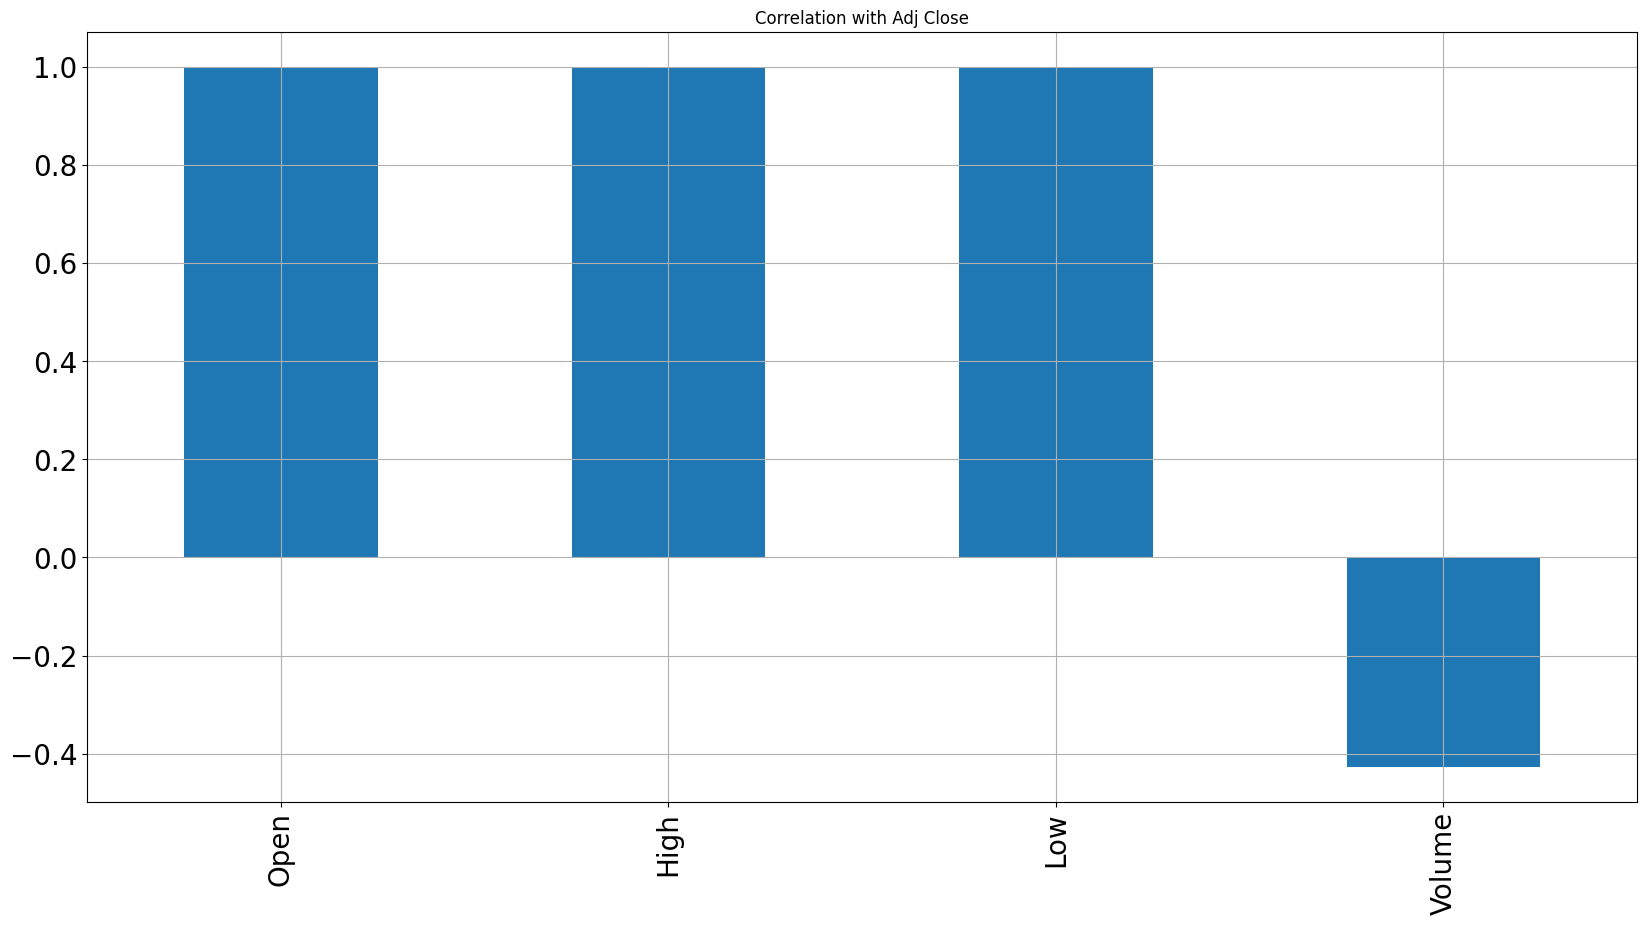

In [15]:
X.corrwith(df_final['Adj Close']).plot.bar(
        figsize = (20, 10), title = "Correlation with Adj Close", fontsize = 20,
        rot = 90, grid = True)

In [16]:
test = df_final
# Target column
target_adj_close = pd.DataFrame(test['Adj Close'])
display(test.head())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-01,19.577499,19.578930,19.241785,19.445356,16.527443,683270000
2012-03-02,19.437143,19.528570,19.375713,19.470715,16.548992,431712400
2012-03-05,19.479286,19.552856,18.785713,19.041430,16.184122,809124400
2012-03-06,18.702143,19.060356,18.436428,18.937857,16.096092,810238800
2012-03-07,19.171429,19.206429,18.689285,18.953215,16.109144,798520800


In [17]:
# selecting Feature Columns
feature_columns = ['Open', 'High', 'Low', 'Volume']

# Normalizing the data

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,Open,High,Low,Volume
Date,,,,
2012-03-01,0.033900,0.031467,0.033188,0.452350
2012-03-02,0.033068,0.031168,0.033998,0.275178
2012-03-05,0.033318,0.031312,0.030430,0.540989
2012-03-06,0.028713,0.028393,0.028318,0.541774
2012-03-07,0.031494,0.029259,0.029847,0.533521


In [19]:
display(feature_minmax_transform.head())
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)

# Shift target array because we want to predict the n + 1 day value


target_adj_close = target_adj_close.shift(-1)
validation_y = target_adj_close[-90:-1]
target_adj_close = target_adj_close[:-90]

# Taking last 90 rows of data to be validation set
validation_X = feature_minmax_transform[-90:-1]
feature_minmax_transform = feature_minmax_transform[:-90]
display(validation_X.tail())
display(validation_y.tail())

print("\n -----After process------ \n")
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)
display(target_adj_close.tail())

,Open,High,Low,Volume
Date,,,,
2012-03-01,0.033900,0.031467,0.033188,0.452350
2012-03-02,0.033068,0.031168,0.033998,0.275178
2012-03-05,0.033318,0.031312,0.030430,0.540989
2012-03-06,0.028713,0.028393,0.028318,0.541774
2012-03-07,0.031494,0.029259,0.029847,0.533521


Shape of features :  (2594, 4)
Shape of target :  (2594, 1)


,Open,High,Low,Volume
Date,,,,
2022-06-13,0.705168,0.716960,0.711671,0.057194
2022-06-14,0.706708,0.709193,0.711913,0.030837
2022-06-15,0.713581,0.729647,0.716025,0.035590
2022-06-16,0.700487,0.700300,0.697157,0.047275
2022-06-17,0.688578,0.704391,0.701814,0.065866


,Adj Close
Date,
2022-06-13,131.971970
2022-06-14,134.626114
2022-06-15,129.287979
2022-06-16,130.779083
2022-06-17,135.063492



 -----After process------ 

Shape of features :  (2504, 4)
Shape of target :  (2504, 1)


,Adj Close
Date,
2022-02-03,171.115326
2022-02-04,170.390717
2022-02-07,173.537262
2022-02-08,174.976532
2022-02-09,170.847305


# Train test Split using Timeseriessplit

In [20]:
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [21]:

X_train.shape

(2277, 4)

In [22]:
X_test.shape

(227, 4)

In [23]:
y_train.shape

(2277,)

In [24]:
y_test.shape

(227,)

In [25]:
def validate_result(model, model_name):
    predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))
    print('RMSE: ', RSME_score)

    R2_score = r2_score(validation_y, predicted)
    print('R2 score: ', R2_score)

    plt.plot(validation_y.index, predicted,'r', label='Predict')
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.ylabel('Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

# Benchmark Model

RMSE:  21.012214560406836
R2 score:  -1.857092050708256


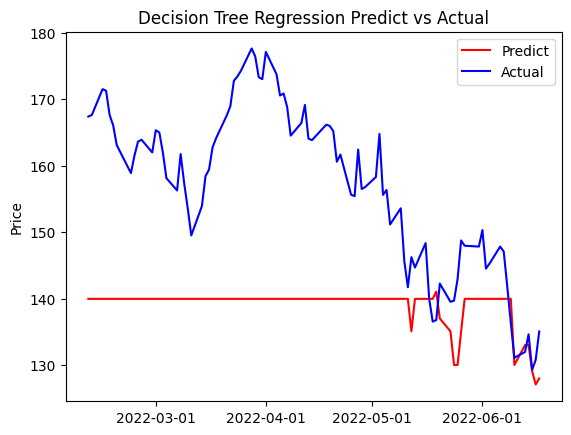

In [26]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=0)

benchmark_dt=dt.fit(X_train, y_train)

validate_result(benchmark_dt, 'Decision Tree Regression')

# Process the data for LSTM

In [27]:
X_train =np.array(X_train)
X_test =np.array(X_test)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Model building : LSTM

In [28]:

from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
285/285 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 616.5540
Epoch 2/200
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 485.7609
Epoch 3/200
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 330.5584
Epoch 4/200
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 177.1523
Epoch 5/200
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 93.7391
Epoch 6/200
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 94.5299
Epoch 7/200
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 135.6424
Epoch 8/200
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 171.5589
Epoch 9/200
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 183.0858
Epoch 10/200
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 172.2115
Epoch 11/200
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 147.8150
Epoch 12/200
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 118.6126
Epoch 13/200
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 89.9314
Epoch 14/200
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 64.5678
Epoch 15/200
285/28

# Evaluation of Model

In [29]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
The R2 score on the Train set is:	0.998
The R2 score on the Test set is:	0.926


## Predictions made by LSTM

In [30]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.8539


In [31]:
print('LSTM: %f'%score_lstm)

LSTM: 20.017126


In [32]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


# LSTM's Prediction Visual

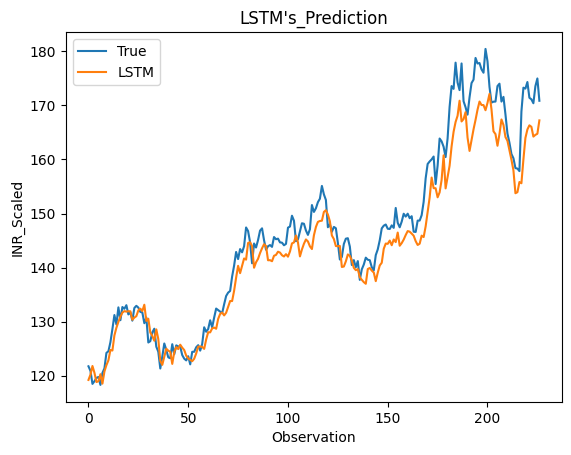

In [33]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()


# Converting Prediction data
In this step I have made the prediction of test data and will convert the dataframe to csv so that we can see the price difference between actual and predicted price.

In [34]:
col1 = pd.DataFrame(y_test, columns=['True'])

col2 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])

col3 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3], axis=1)
results.to_excel('PredictionResults_LSTM_NonShift.xlsx')

# Conclusion

It is impossible to  get a model that can 99% predict the price without any error, there are too many factors can affect the
stock prices. So, we cannot hope there is a perfect model, but the general trend of predicted price is in line with the actual data, so the trader could have an indicator to reference, and makes trading decision by himself.


Further, we can improve the model's accuracy by increasing the epochs, trying out different activation functions or even change the model's structure. As exact